# Hands on session: Autoencoders (2)
This is the second of two examples, where we will use Autoencoders to reduce the dimensionality of the calcium imaging data. We will now use a different dataset, which contains the spike times points of >100 neurons along with the behavioral data of a mouse.

In this example, we encode the calcium data for each time point, i.e., we represent the activity of all neurons (neuron population response) at each time point in a lower-dimensional space. This is different from the previous example, where we represented the activity of each neuron in a lower-dimensional space, compressing the time information. 

This exercise refers to Chapter 4 "Autoencoders" of the "Dimensionality reduction in neuroscience" course (tutor: Fabrizio Musacchio, Oct 17, 2024)

## Acknowledgements:
The dataset used here is extracted from the the datasets available in the [CEBRA package](https://cebra.ai/docs/demo_notebooks/Demo_hippocampus.html).

## Dataset
The dataset consists of several sub-structures:
- `neuron_spike_times`: A binary matrix of shape `(N_rec, n_timepoints)` where `N_rec=120` is the number of
    recorded neurons and `n_timepoints=1000` is the number of timepoints in the recording. A value of 1 indicates
    a spike from a neuron at a given timepoint.
- `position_readout`: A vector of shape `(n_timepoints)`, representing the position of the mouse at each timepoint.
- `left_direction`: A binary vector of shape `(n_timepoints)`, indicating whether the mouse is moving in the left direction.
- `right_direction`: A binary vector of shape `(n_timepoints)`, indicating whether the mouse is moving in the right direction.
- `N_rec`: The number of recorded neurons.

## Environment setup
For reproducibility:

```bash
conda create -n dimredcution python=3.11 mamba -y
conda activate dimredcution
mamba install ipykernel matplotlib numpy scipy scikit-learn -y
mamba install pytorch torchvision -c pytorch
```

Let's load the necessary libraries:

In [1]:
# %% IMPORTS
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
import pickle

from mpl_toolkits import mplot3d
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim

# verify torch version and GPU availability:
print(f"torch backend MPS is available? {torch.backends.mps.is_available()}")
print(f"current PyTorch installation built with MPS activated? {torch.backends.mps.is_built()}")
print(f"check the torch MPS backend: {torch.device('mps')}")
print(f"test torch tensor on MPS: {torch.tensor([1,2,3], device='mps')}")
""" 
On macOS: Don't forget to move your model to the MPS device, if you want to use it:

device = torch.device('mps')
model = model.to(device)
"""

# set global properties for all plots:
plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"]   = False
plt.rcParams["axes.spines.right"]  = False

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <253997FD-685F-34A9-B3D7-4AF6DAE96CDF> /Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you c

torch backend MPS is available? True
current PyTorch installation built with MPS activated? True
check the torch MPS backend: mps
test torch tensor on MPS: tensor([1, 2, 3], device='mps:0')


Define the path to the dataset:

In [2]:
DATA_PATH = '../data/'
DATA_FILENAME = 'hippocampus_achilles_from_cebra_dict.pkl'
DATA_FILE = os.path.join(DATA_PATH, DATA_FILENAME)

RESULTSPATH = '../results/'
# check whether the results path exists, if not, create it:
if not os.path.exists(RESULTSPATH):
    os.makedirs(RESULTSPATH)

Load the dataset:

In [4]:
hippocampus_achilles_dict = pickle.load(open(DATA_FILE, 'rb'))

neuron_spike_times = hippocampus_achilles_dict['neuron_spike_times']
position_readout   = hippocampus_achilles_dict['position_readout']
left_direction     = hippocampus_achilles_dict['left_direction']
right_direction    = hippocampus_achilles_dict['right_direction']
N_rec              = hippocampus_achilles_dict['N_rec']
n_timepoints       = neuron_spike_times.shape[1]

# extract the neurons and timepoints for the scatter plot:
neurons, timepoints = np.where(neuron_spike_times)

Let's take a look at the dataset:

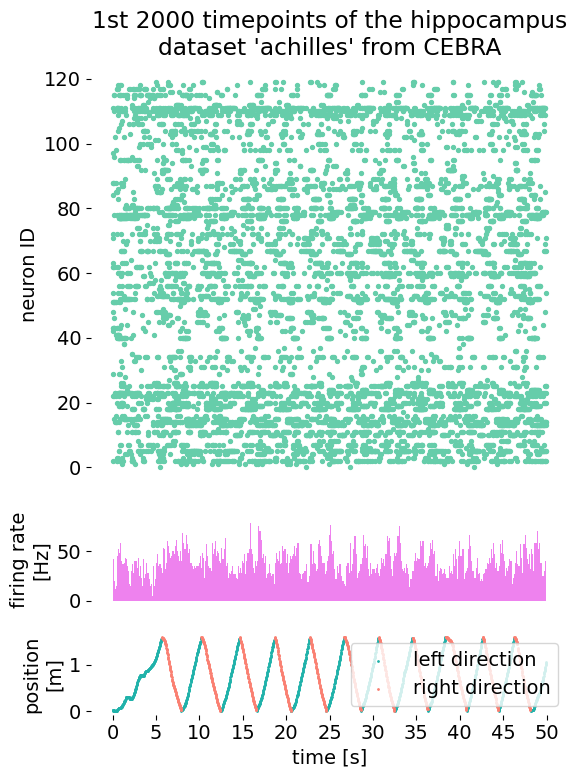

In [5]:
# spike raster plot and histogram of spiking rate:
fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(6, 1)

# create the first subplot (3/4 of the figure)
ax1 = plt.subplot(gs[0:4, :])
ax1.scatter(timepoints, neurons, s=8.0, color='mediumaquamarine', alpha=1.0)
#ax1.imshow(neuron_spike_times, aspect='auto', cmap='viridis', interpolation='none')
plt.title(f"1st {n_timepoints} timepoints of the hippocampus\ndataset 'achilles' from CEBRA")
#ax1.set_xlabel("time [ms]")
ax1.set_xticks([])
ax1.set_ylabel("neuron ID")

# create the second subplot:
ax2 = plt.subplot(gs[4, :])
hist_binwidth = 5.0
t_bins = np.arange(np.amin(timepoints), np.amax(timepoints), hist_binwidth)
n, bins = np.histogram(timepoints, bins=t_bins)
heights = 1000 * n / (hist_binwidth * (N_rec))
ax2.bar(t_bins[:-1], heights, width=hist_binwidth, color='violet')
ax2.set_ylabel("firing rate\n[Hz]")
ax2.set_xticks([])

# create the third subplot:
ax3 = plt.subplot(gs[5, :])
#ax3.plot(np.arange(1000), position_readout, c = 'k')
ax3.scatter(np.arange(n_timepoints)[left_direction == 1],  position_readout[left_direction == 1], 
         c='lightseagreen', label='left direction', s=1)
ax3.scatter(np.arange(n_timepoints)[right_direction == 1], position_readout[right_direction == 1], 
         c='salmon', label='right direction', s=1)
ax3.set_ylabel(f'position\n[m]')
ax3.set_xlabel("time [s]")
ax3.legend(loc="upper right", frameon=True)
ax3.set_xticks(np.arange(0, n_timepoints+1, 200))
ax3.set_xticklabels(np.arange(0, 0.025*n_timepoints+1, 0.025*200).astype("int")) 

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'AE_behavior_hippocampus_achilles_spike_raster.png'), dpi=300)
plt.show()

We need to rearange the data. This time, we need to **feed both neural spike times and position readout** into the autoencoder. This means concatenating the two data types into a single input vector for the AE:

In [8]:
# concatenate neural data and position readout:
neuron_spike_times_flat = neuron_spike_times.T  # shape: (timepoints, neurons)
position_readout_flat   = position_readout.reshape(-1, 1)  # reshape to (timepoints, 1)

# concatenate along the feature axis (columns):
combined_data = np.hstack((neuron_spike_times_flat, position_readout_flat))

print(f"Combined data shape: {combined_data.shape}")  # should be (timepoints, neurons + 1)

Combined data shape: (2000, 121)


We again define a custom dataset class for PyTorch' DataLoader. The `CustomDataset` class needs to be modified to include both the neural spike times and the behavior data as inputs for the model:

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]  # Number of timepoints
    
    def __getitem__(self, idx):
        instance = self.data[idx, :]  # Return the combined data for the given timepoint
        sample = {"data": instance}
        return sample

We convert the combined data to a tensor and apply the `CustomDataset` class:

In [9]:
# convert the combined data to a tensor
combined_data_tensor = torch.tensor(combined_data).float()

# apply the CustomDataset class to the combined data tensor:
combined_dataset_tensor = CustomDataset(combined_data_tensor)

# check the dimensions:
print(f"Dataset shape: {combined_dataset_tensor.__getitem__(0)['data'].shape}")

Dataset shape: torch.Size([121])


Next, we split the dataset into training (90%) and test (10%) sets:

In [10]:
# define the training (90%) and testing set sizes (10%):
train_size = int(np.floor(0.9 * len(combined_dataset_tensor)))
test_size  = len(combined_dataset_tensor) - train_size

# create subsets for training and testing:
train_indices, test_indices = torch.utils.data.random_split(range(len(combined_dataset_tensor)), [train_size, test_size])

train_dataset = Subset(combined_dataset_tensor, train_indices)
test_dataset  = Subset(combined_dataset_tensor, test_indices)

# create DataLoaders for the training and testing sets:
train_loader = DataLoader(dataset=train_dataset, batch_size=150, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=150, shuffle=True)


## 📝 Define the Autoencoder
We need to redefine the Autoencoder class from the previous exercise to include the concatenated neural and behavioral data. Also the input size has changed: If the neural data has `N_rec` neurons and ?n_timepoints? timepoints, and the position data is 1-dimensional, then the input size will be `N_rec+1`.

1. Create an Autoencoder class, e.g., called `TemporalAutoencoder` that inherits from `nn.Module`.
2. Create an `encoder` with the following layers:
    - A linear layer with input size `input_size` and output size `64`.
    - A ReLU activation function.
    - A linear layer with input size `64` and output size `32`.
    - A ReLU activation function.
    - A linear layer with input size `32` and output size `latent_size`, where `latent_size` is the definable latent space dimension.
3. Create an according `decoder`.
4. Define the `forward` pass.


In [11]:
# Your code goes here:

#class TemporalAutoencoder(...):
#    def __init__(self, input_size, latent_size):
#        super().__init__()
#        
        # Encoder: 
#        self.encoder = torch.nn.Sequential(
#            ...
#        )
#        
        # Decoder: reconstruct the original neural activity from latent space
#        self.decoder = torch.nn.Sequential(
#            ...
#        )
#        
#    def forward(self, x):
#        ...
#        return latent, reconstructed


# SOL:
class TemporalAutoencoder(torch.nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        
        # Encoder: compress each time frame's neural activity
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 64),   # Compress from 120 neurons to 64
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),           # Further compression
            torch.nn.ReLU(),
            torch.nn.Linear(32, latent_size)   # Compress into latent space (e.g., 3)
        )
        
        # Decoder: reconstruct the original neural activity from latent space
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, input_size)    # Reconstruct back to 120 neurons
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

## 📝  Create the autoencoder with the appropriate input size
1. The input size is the number of neurons plus one (for the position data). Hint: You can extract it from the combined data tensor.
2. Define the latent space dimension `latent_size=3`.

In [12]:
# Your code goes here:

# input_size  = ...
# latent_size = ... 
# model = TemporalAutoencoder(...)

# move the model to the MPS device
# device = torch.device('mps')
# model = model.to(device)

# SOL:
input_size = combined_data.shape[1]  # neurons + position
latent_size = 3  # number of latent dimensions
model = TemporalAutoencoder(input_size, latent_size)

# Move the model to the MPS device
device = torch.device('mps')
model = model.to(device)

## 📝  Train the autoencoder
The training loop remains largely the same. The loss function (MSELoss) will now compute the reconstruction error over both the neural and behavioral data.

Prepare and create a training loop to train the autoencoder on the training data:
1. Train the autoencoder for 250 epochs.
2. Keep track of the training and validation losses.
3. As loss function, use the Mean Squared Error (MSE) loss (`torch.nn.MSELoss()`).
4. Use the Adam optimizer (`torch.optim.Adam(...)`) with an initial learning rate of 1e-2, a `weight_decay` of 1e-8 and a `step_size` of 1.
5. Follow further instructions below to complete the code.

In [13]:
# Your code goes here:

# set the training parameters:
# epochs       = 249

# prepare lists to store the training and validation losses
# train_losses = []
# val_losses   = []

# define the loss function and optimizer:
# loss_function = ...
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(...)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.98)

#for epoch in range(epochs):
#    model.train()
#    train_loss = 0.0
#    for batch in train_loader:
#        batch_data = batch['data'].to(device)
#        
        # STEP 1: Forward pass
#        latent, reconstructed = ...
        
        # STEP 2: Compute loss
#        loss = ...
        
        # backpropagation and optimization (just uncomment the following lines)
#        optimizer.zero_grad()
#        loss.backward()
#       optimizer.step()
        
        # add the loss to the training loss
        # train_loss += ...
    
    # average training loss: (just uncomment the following line)
    #avg_train_loss = train_loss / len(train_loader)
    #train_losses.append(avg_train_loss)
    
    # Validation phase:
    # model.eval()
    # val_loss = 0.0
#    with torch.no_grad():
#        for val_batch in test_loader:
#            val_batch_data = ...
#            latent_val, reconstructed_val = ...
#            val_loss += ...
    
    # just uncomment the following lines:
#    avg_val_loss = val_loss / len(test_loader)
#    val_losses.append(avg_val_loss)
#    
#    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')


# SOL:
# set the training parameters:
epochs = 249
train_losses = []
val_losses = []

# Define the loss function and optimizer
loss_function = torch.nn.MSELoss()
learning_rate = 1e-3 # 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.98)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch_data = batch['data'].to(device)
        
        # Forward pass
        latent, reconstructed = model(batch_data)
        
        # Compute loss
        loss = loss_function(reconstructed, batch_data)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in test_loader:
            val_batch_data = val_batch['data'].to(device)
            latent_val, reconstructed_val = model(val_batch_data)
            val_loss += loss_function(reconstructed_val, val_batch_data).item()
    
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

Epoch 1/249, Train Loss: 0.093367, Val Loss: 0.083987
Epoch 2/249, Train Loss: 0.081616, Val Loss: 0.079714
Epoch 3/249, Train Loss: 0.076017, Val Loss: 0.077588
Epoch 4/249, Train Loss: 0.072808, Val Loss: 0.072459
Epoch 5/249, Train Loss: 0.070823, Val Loss: 0.076062
Epoch 6/249, Train Loss: 0.069162, Val Loss: 0.071568
Epoch 7/249, Train Loss: 0.067132, Val Loss: 0.070146
Epoch 8/249, Train Loss: 0.064472, Val Loss: 0.068864
Epoch 9/249, Train Loss: 0.061858, Val Loss: 0.061505
Epoch 10/249, Train Loss: 0.059578, Val Loss: 0.061669
Epoch 11/249, Train Loss: 0.057623, Val Loss: 0.058129
Epoch 12/249, Train Loss: 0.056070, Val Loss: 0.056978
Epoch 13/249, Train Loss: 0.054747, Val Loss: 0.056219
Epoch 14/249, Train Loss: 0.053602, Val Loss: 0.053172
Epoch 15/249, Train Loss: 0.052640, Val Loss: 0.053394
Epoch 16/249, Train Loss: 0.051874, Val Loss: 0.053183
Epoch 17/249, Train Loss: 0.051257, Val Loss: 0.053192
Epoch 18/249, Train Loss: 0.050712, Val Loss: 0.052161
Epoch 19/249, Train

## 📝 Assess the loss curves
1. Plot the training and validation loss curves (i.e., your previously stored losses).
2. What do you observe?

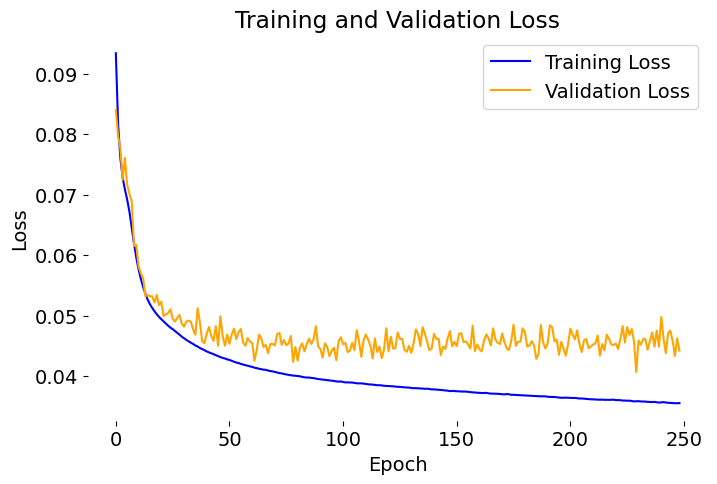

In [14]:
# Your code goes here:

# SOL:
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Next, we extract the AE latent space representation from the full dataset (instead of the training set only):

In [16]:
# Extract latent space representation from the full dataset
model.eval()
latent_space = []
with torch.no_grad():
    for batch in DataLoader(dataset=combined_dataset_tensor, batch_size=128, shuffle=False):
        batch_data = batch['data'].to(device)
        latent, _ = model(batch_data)
        latent_space.append(latent.cpu().numpy())

# concatenate latent space results:
latent_space = np.concatenate(latent_space, axis=0)

## 📝 Visualize the latent space
1. Plot the latent space representation of the full dataset in 3D.
2. Plot 2D projections of the latent space representation (3x, in separate plots of a subplot).
3. What do you observe?

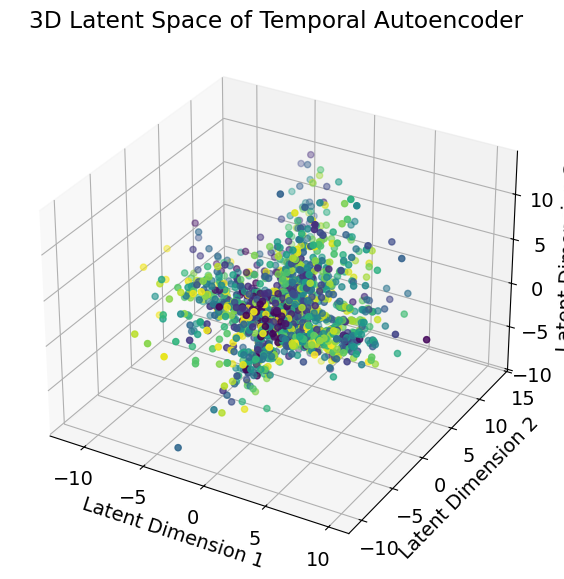

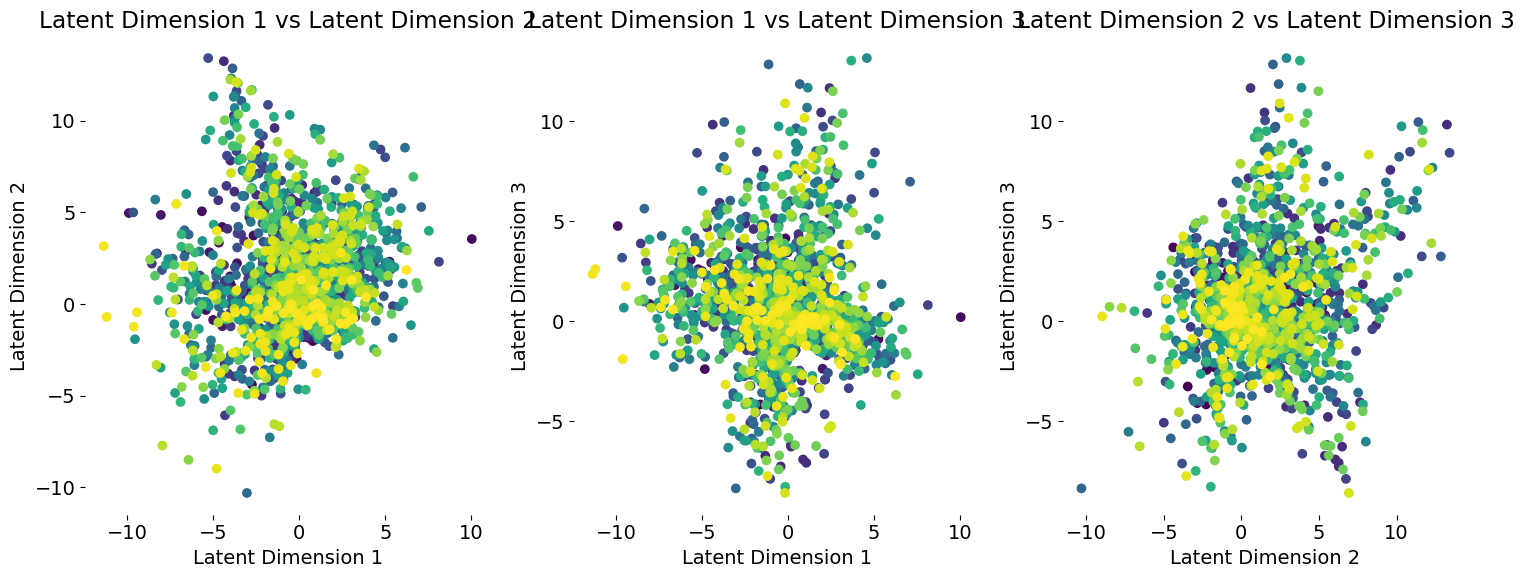

In [17]:
# Your code goes here:


# SOL
# Plot the 3D latent space:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=np.arange(len(latent_space)), cmap='viridis')
ax.set_title("3D Latent Space of Temporal Autoencoder")
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.tight_layout()
plt.show()

# Plot the 2D latent space:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 6))
ax0.scatter(latent_space[:, 0], latent_space[:, 1], c=np.arange(len(latent_space)), cmap='viridis')
ax0.set_title("Latent Dimension 1 vs Latent Dimension 2")
ax0.set_xlabel('Latent Dimension 1')
ax0.set_ylabel('Latent Dimension 2')

ax1.scatter(latent_space[:, 0], latent_space[:, 2], c=np.arange(len(latent_space)), cmap='viridis')
ax1.set_title("Latent Dimension 1 vs Latent Dimension 3")
ax1.set_xlabel('Latent Dimension 1')
ax1.set_ylabel('Latent Dimension 3')

ax2.scatter(latent_space[:, 1], latent_space[:, 2], c=np.arange(len(latent_space)), cmap='viridis')
ax2.set_title("Latent Dimension 2 vs Latent Dimension 3")
ax2.set_xlabel('Latent Dimension 2')
ax2.set_ylabel('Latent Dimension 3')
plt.tight_layout()
plt.show()


## 📝 Cluster the embedded latent space variables
1. Cluster the embedded latent space variables using KMeans with 4 clusters.
2. Visualize the clusters in the 3D latent space.

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_5981/717103123.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')


unique labels: [0 1 2 3]


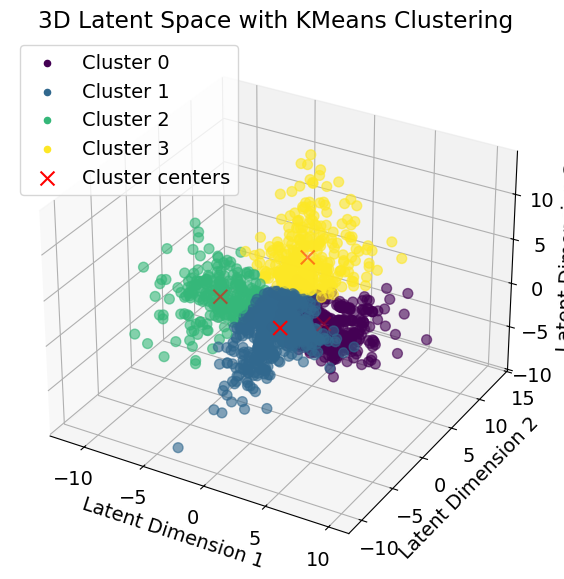

In [18]:
# Your code goes here:

# SOL:
# cluster the latent space:
n_clusters = 4
kmeans_fit = KMeans(n_clusters=n_clusters, random_state=42).fit(latent_space)
print(f"unique labels: {np.unique(kmeans_fit.labels_)}")

# plot the 3D latent space with the kmeans cluster labels:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_space[:, 0], latent_space[:, 1], latent_space[:, 2], c=kmeans_fit.labels_, cmap='viridis', marker='o', s=50, alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
# plot the cluster centers:
ax.scatter(kmeans_fit.cluster_centers_[:, 0], kmeans_fit.cluster_centers_[:, 1],
              kmeans_fit.cluster_centers_[:, 2], c='red', s=100, marker='x', zorder=11, label='Cluster centers')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.legend()
plt.title('3D Latent Space with KMeans Clustering')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'AE_latent_space_kmeans_{n_clusters}_clusters.png'), dpi=300)
plt.show()


## 📝 Plot the behavior vector with cluster labels
Plot the behavior vector with the cluster labels as colors and interprete the result.

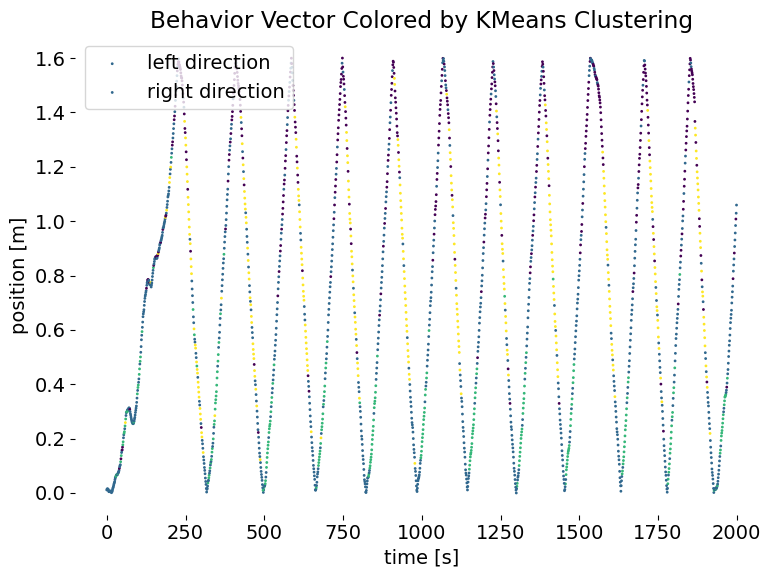

In [19]:
# plot the behavior vector, color-coded by the kmeans cluster labels:
fig = plt.figure(figsize=(8, 6))
plt.scatter(np.arange(n_timepoints)[left_direction == 1],  position_readout[left_direction == 1],
            c=kmeans_fit.labels_[left_direction == 1], cmap='viridis', label='left direction', s=1)
plt.scatter(np.arange(n_timepoints)[right_direction == 1], position_readout[right_direction == 1],
            c=kmeans_fit.labels_[right_direction == 1], cmap='viridis', label='right direction', s=1)
plt.xlabel('time [s]')
plt.ylabel('position [m]')
plt.title('Behavior Vector Colored by KMeans Clustering')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'AE_behavior_vector_kmeans_{n_clusters}_clusters.png'), dpi=300)



 ## 📝 Perform a PCA for comparison
 Perform a PCA on the combined data `combined_data` and plot the results in 3D and 2D. Compare the results with the autoencoder latent space representation.

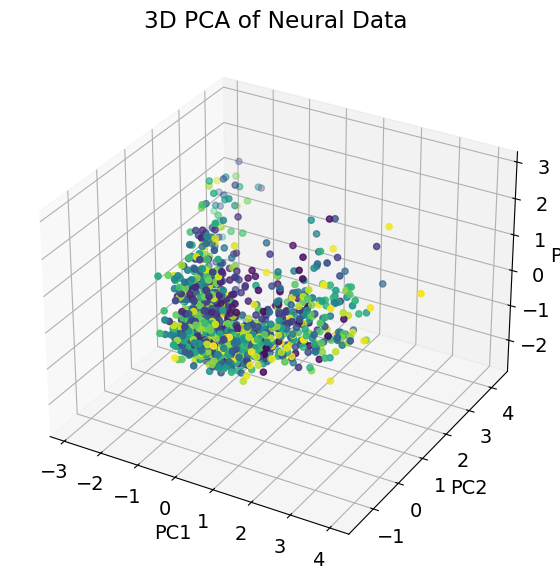

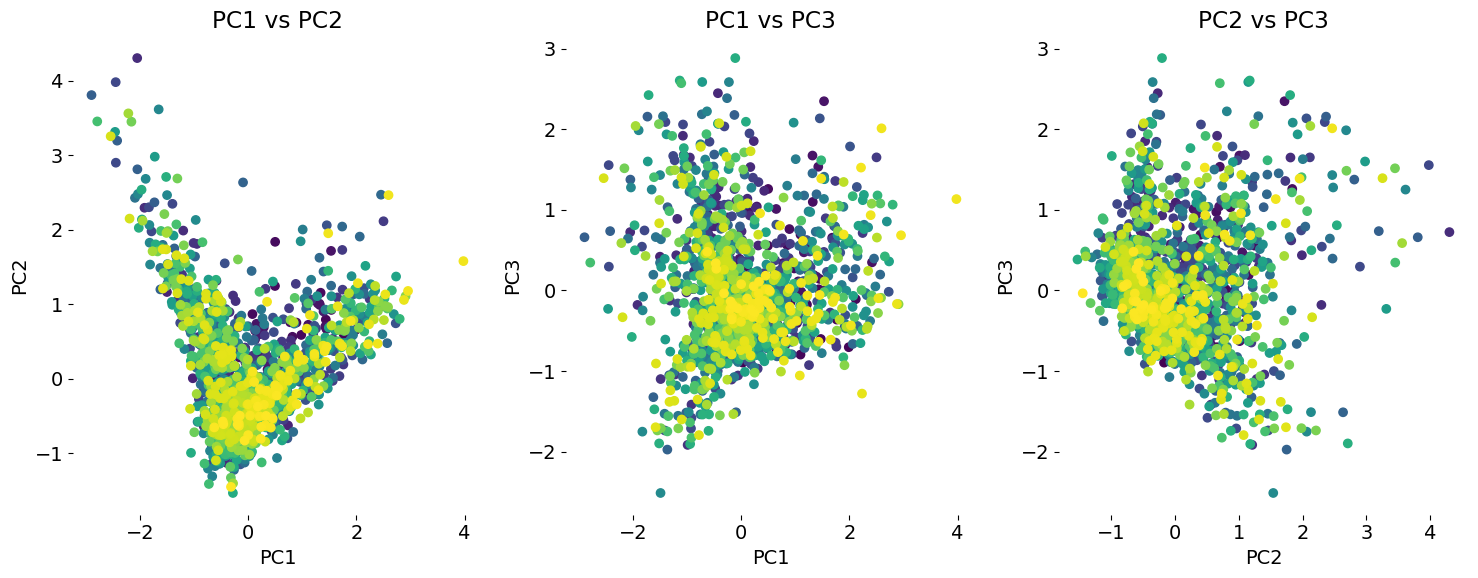

In [21]:

# perform PCA with 3 PCs for comparison:
PCA_model = PCA(n_components=3)
PCA_model_fit = PCA_model.fit_transform(combined_data)
PCA_model_fit.shape

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_model_fit[:, 0], PCA_model_fit[:, 1], PCA_model_fit[:, 2], c=np.arange(len(PCA_model_fit)), cmap='viridis')
ax.set_title("3D PCA of Neural Data")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

# 2D PCA plot:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 6))
ax0.scatter(PCA_model_fit[:, 0], PCA_model_fit[:, 1], c=np.arange(len(PCA_model_fit)), cmap='viridis')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')

ax1.scatter(PCA_model_fit[:, 0], PCA_model_fit[:, 2], c=np.arange(len(PCA_model_fit)), cmap='viridis')
ax1.set_title("PC1 vs PC3")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC3')

ax2.scatter(PCA_model_fit[:, 1], PCA_model_fit[:, 2], c=np.arange(len(PCA_model_fit)), cmap='viridis')
ax2.set_title("PC2 vs PC3")
ax2.set_xlabel('PC2')
ax2.set_ylabel('PC3')
plt.tight_layout()
plt.show()

## 📝 Cluster the PCA results
Cluster the PCA results using KMeans with 4 clusters and visualize the clusters in the 3D latent space.

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_5981/2832235471.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')


unique labels: [0 1 2 3]


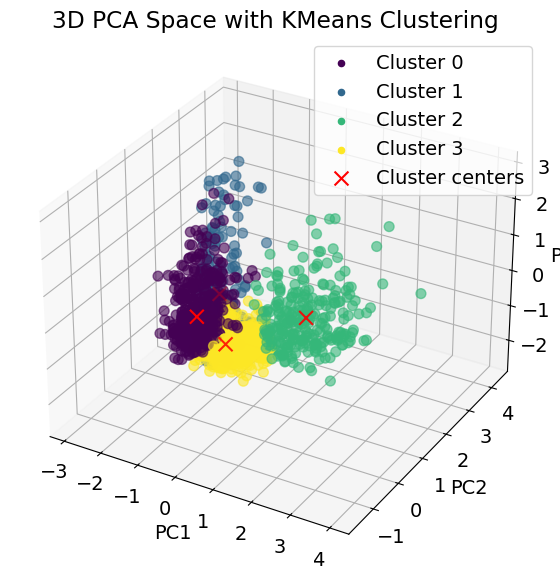

In [23]:

# cluster the PCA space:
n_clusters = 4
kmeans_fit_PCA = KMeans(n_clusters=n_clusters, random_state=42).fit(PCA_model_fit)
print(f"unique labels: {np.unique(kmeans_fit_PCA.labels_)}")

# plot the 3D PCA space with the kmeans cluster labels:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(PCA_model_fit[:, 0], PCA_model_fit[:, 1], PCA_model_fit[:, 2], c=kmeans_fit_PCA.labels_, cmap='viridis', marker='o', s=50,
                        alpha=0.6)
# add a dummy plot just for indicating cluster labels:
for i in range(n_clusters):
    ax.scatter([], [], [], c=plt.cm.viridis(i / (n_clusters - 1)), label=f'Cluster {i}')
# plot the cluster centers:
ax.scatter(kmeans_fit_PCA.cluster_centers_[:, 0], kmeans_fit_PCA.cluster_centers_[:, 1],
              kmeans_fit_PCA.cluster_centers_[:, 2], c='red', s=100, marker='x', zorder=11, label='Cluster centers')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.title('3D PCA Space with KMeans Clustering')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'PCA_latent_space_kmeans_{n_clusters}_clusters.png'), dpi=300)
plt.show()


## 📝 Plot the behavior vector color-labeled based on the PCA clusters and interpret the results.

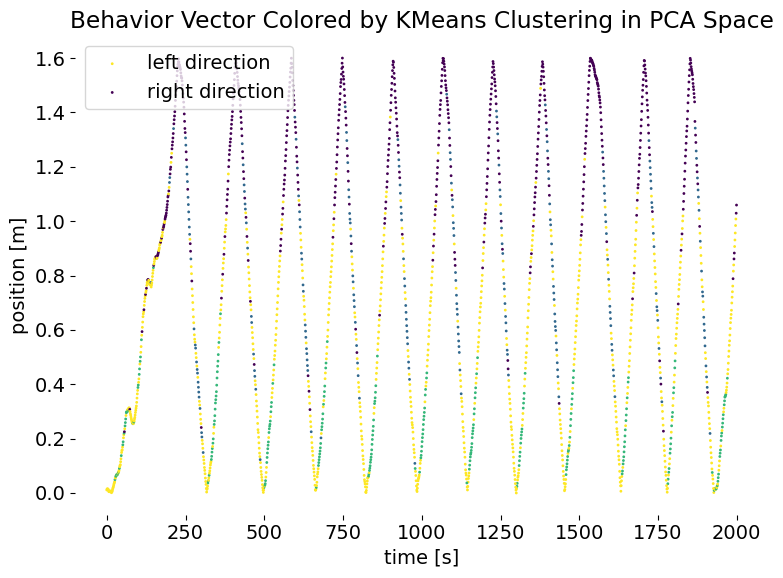

In [24]:
# plot the behavior vector, color-coded by the kmeans cluster labels:
fig = plt.figure(figsize=(8, 6))
plt.scatter(np.arange(n_timepoints)[left_direction == 1],  position_readout[left_direction == 1],
            c=kmeans_fit_PCA.labels_[left_direction == 1], cmap='viridis', label='left direction', s=1)
plt.scatter(np.arange(n_timepoints)[right_direction == 1], position_readout[right_direction == 1],
            c=kmeans_fit_PCA.labels_[right_direction == 1], cmap='viridis', label='right direction', s=1)
plt.xlabel('time [s]')
plt.ylabel('position [m]')
plt.title('Behavior Vector Colored by KMeans Clustering in PCA Space')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, f'PCA_behavior_vector_kmeans_{n_clusters}_clusters.png'), dpi=300)
plt.show()

## Bonus: Predicting behavior from neural activity
To further assess whether our neural data follows a hidden structure that is related to the behavior, we can test how good the data is embedded in the latent space to predict the behavior. 

To do so, we need to add a behavior prediction layer to the latent space of the autoencoder and we need to extend the forward pass accordingly: 


In [25]:
class AutoencoderWithBehavior(nn.Module):
    def __init__(self, input_size, latent_size, output_size):
        super(AutoencoderWithBehavior, self).__init__()
        
        # Encoder: 
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size)  # Latent space
        )
        
        # Decoder: 
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size)  # Reconstruct original neural activity
        )
        
        # Behavior Prediction: Predict behavior from the latent space
        self.behavior_predictor = nn.Sequential(
            nn.Linear(latent_size, 16),  # Use the latent space as input
            nn.ReLU(),
            nn.Linear(16, output_size)   # Output the predicted behavior (e.g., position)
        )
    
    def forward(self, x):
        # Pass input through the encoder to get the latent space
        latent = self.encoder(x)
        
        # Reconstruct the original input (autoencoder output, optional)
        reconstruction = self.decoder(latent)
        
        # Predict behavior from the latent space
        predicted_behavior = self.behavior_predictor(latent)
        
        return latent, reconstruction, predicted_behavior

We initialize the model as we have done before, but now we have an additional output_size parameter for the behavior prediction, which is set to 1 in this case:

In [26]:
# initialize the model:
latent_size = 3  # Latent space dimension
output_size = 1  # predicting 1 behavior (e.g., position)
model = AutoencoderWithBehavior(input_size=120, latent_size=latent_size, output_size=output_size).to(device)

# loss functions and optimizers:
ae_loss_function = nn.MSELoss()  # for reconstructing the input in the AE
behavior_loss_function = nn.MSELoss()  # for predicting the behavior
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We also need to redefine the train loader:

In [28]:
# create the dataset where inputs are neural activity and targets are behavior:
class NeuralToBehaviorDataset(Dataset):
    def __init__(self, neural_data, behavior_data):
        self.neural_data = neural_data  # Neural activity (2000 time frames, 120 neurons)
        self.behavior_data = behavior_data  # Behavior data (2000 time frames, 1 behavior)
        
    def __len__(self):
        return self.neural_data.shape[0]  # Number of time frames
    
    def __getitem__(self, idx):
        neural_activity = self.neural_data[idx, :]  # Neural data at time frame idx
        behavior = self.behavior_data[idx]          # Behavior at time frame idx
        return {"neural_activity": neural_activity, "behavior": behavior}

# use the neural activity and behavior data from your existing dataset:
neural_activity = neuron_spike_times.T  # Neural data (time points x neurons) shape: (2000, 120)
behavior = position_readout.reshape(-1, 1)  # Behavior data, shape: (2000, 1)

# convert to tensors:
neural_activity_tensor = torch.tensor(neural_activity).float()
behavior_tensor = torch.tensor(behavior).float()

# create the dataset:
neural_behavior_dataset = NeuralToBehaviorDataset(neural_activity_tensor, behavior_tensor)

# split into training and testing sets:
train_size = int(0.9 * len(neural_behavior_dataset))  # 90% for training
test_size = len(neural_behavior_dataset) - train_size  # 10% for testing

train_dataset, test_dataset = torch.utils.data.random_split(neural_behavior_dataset, [train_size, test_size])

# create DataLoaders for training and testing:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

/var/folders/zm/449byhrj6kd2779zy8fs0nvr0000gq/T/ipykernel_5981/2713187148.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  behavior_tensor = torch.tensor(behavior).float()


We also need to adjust the training loop to include the behavior prediction loss. We need to compute the behavior prediction loss and add it to the total loss:

In [29]:
# training loop:
epochs = 100
train_ae_losses = []
train_behavior_losses = []
val_ae_losses = []
val_behavior_losses = []

for epoch in range(epochs):
    model.train()
    
    train_loss_ae = 0.0
    train_loss_behavior = 0.0
    
    # Training phase
    for batch in train_loader:
        neural_activity = batch['neural_activity'].to(device)
        behavior = batch['behavior'].to(device)
        
        # Forward pass through the model
        latent, reconstructed, predicted_behavior = model(neural_activity)
        
        # Compute the losses
        loss_ae = ae_loss_function(reconstructed, neural_activity)  # Autoencoder loss
        loss_behavior = behavior_loss_function(predicted_behavior, behavior)  # Behavior prediction loss
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss = loss_ae + loss_behavior  # Sum the losses
        total_loss.backward()
        optimizer.step()
        
        train_loss_ae += loss_ae.item()
        train_loss_behavior += loss_behavior.item()
    
    # Average training losses
    train_ae_losses.append(train_loss_ae / len(train_loader))
    train_behavior_losses.append(train_loss_behavior / len(train_loader))
    
    # Validation phase
    model.eval()
    val_loss_ae = 0.0
    val_loss_behavior = 0.0
    with torch.no_grad():
        for val_batch in test_loader:
            neural_activity_val = val_batch['neural_activity'].to(device)
            behavior_val = val_batch['behavior'].to(device)
            
            # Forward pass
            latent_val, reconstructed_val, predicted_behavior_val = model(neural_activity_val)
            
            # Compute validation losses
            val_loss_ae += ae_loss_function(reconstructed_val, neural_activity_val).item()
            val_loss_behavior += behavior_loss_function(predicted_behavior_val, behavior_val).item()
    
    # Average validation losses
    val_ae_losses.append(val_loss_ae / len(test_loader))
    val_behavior_losses.append(val_loss_behavior / len(test_loader))
    
    print(f'Epoch {epoch+1}/{epochs}, Train AE Loss: {train_ae_losses[-1]:.6f}, Train Behavior Loss: {train_behavior_losses[-1]:.6f}, '
          f'Val AE Loss: {val_ae_losses[-1]:.6f}, Val Behavior Loss: {val_behavior_losses[-1]:.6f}')

Epoch 1/100, Train AE Loss: 0.081924, Train Behavior Loss: 0.848283, Val AE Loss: 0.074958, Val Behavior Loss: 0.789599
Epoch 2/100, Train AE Loss: 0.075135, Train Behavior Loss: 0.629747, Val AE Loss: 0.067472, Val Behavior Loss: 0.502018
Epoch 3/100, Train AE Loss: 0.071606, Train Behavior Loss: 0.337637, Val AE Loss: 0.068830, Val Behavior Loss: 0.285371
Epoch 4/100, Train AE Loss: 0.069228, Train Behavior Loss: 0.233028, Val AE Loss: 0.069284, Val Behavior Loss: 0.184111
Epoch 5/100, Train AE Loss: 0.070869, Train Behavior Loss: 0.150878, Val AE Loss: 0.069024, Val Behavior Loss: 0.142336
Epoch 6/100, Train AE Loss: 0.070943, Train Behavior Loss: 0.119433, Val AE Loss: 0.069165, Val Behavior Loss: 0.116848
Epoch 7/100, Train AE Loss: 0.073295, Train Behavior Loss: 0.099981, Val AE Loss: 0.068099, Val Behavior Loss: 0.102509
Epoch 8/100, Train AE Loss: 0.070501, Train Behavior Loss: 0.088661, Val AE Loss: 0.066109, Val Behavior Loss: 0.096737
Epoch 9/100, Train AE Loss: 0.068723, Tr

## 📝 Plot the training and validation loss curves
1. Plot the training and validation losses for the autoencoder.
2. Plot the training and validation losses for the behavior prediction.

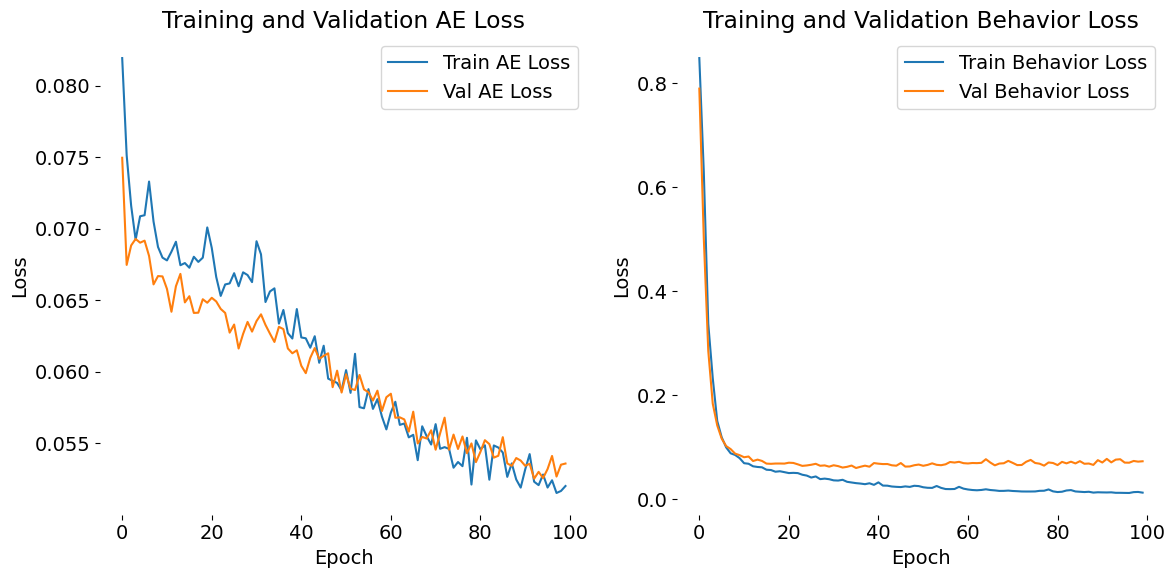

In [30]:
# Your code goes here:

# SOL:
# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Autoencoder loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_ae_losses, label='Train AE Loss')
plt.plot(range(epochs), val_ae_losses, label='Val AE Loss')
plt.title('Training and Validation AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Behavior prediction loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_behavior_losses, label='Train Behavior Loss')
plt.plot(range(epochs), val_behavior_losses, label='Val Behavior Loss')
plt.title('Training and Validation Behavior Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Next, we again extract the latent space representation from the full dataset to plot it in the 3D latent space:

In [31]:
# evaluate on the full dataset:
full_loader = DataLoader(dataset=neural_behavior_dataset, batch_size=128, shuffle=False)

# collect predictions and actuals for the entire dataset:
model.eval()
full_predictions = []
full_actuals = []

with torch.no_grad():
    for batch in full_loader:
        neural_activity = batch['neural_activity'].to(device)
        behavior = batch['behavior'].to(device)
        
        # Get predictions
        _, _, predicted_behavior = model(neural_activity)
        
        # Append the predictions and actuals
        full_predictions.append(predicted_behavior.cpu().numpy())
        full_actuals.append(behavior.cpu().numpy())

# concatenate predictions and actuals for the full dataset:
full_predictions = np.concatenate(full_predictions, axis=0)
full_actuals = np.concatenate(full_actuals, axis=0)

## 📝 Plot the actual vs. predicted behavior

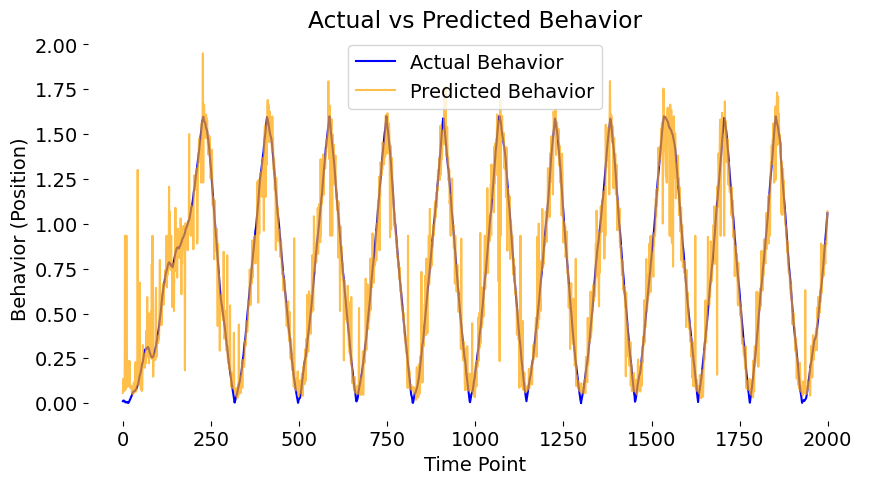

In [32]:
# Your code goes here:

# SOL:
# Plot the actual vs predicted behavior
plt.figure(figsize=(10, 5))
plt.plot(full_actuals, label='Actual Behavior', color='blue')
plt.plot(full_predictions, label='Predicted Behavior', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Behavior')
plt.xlabel('Time Point')
plt.ylabel('Behavior (Position)')
plt.legend()
plt.show()

In [ ]:
# %% END